# ИТОГОВЫЙ ПРОЕКТ ПО КУРСУ "БИБЛИОТЕКИ PYTHON ДЛЯ DATA SCIENCE"

## REAL ESTATE PRICE PREDICTION

In [ ]:
# предсказать цены на квартиры в датасете test.csv. 
# даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).
# Метрика качества:
# R2 - коэффициент детерминации (sklearn.metrics.r2_score)

## Описание датасета:

In [ ]:
# Id - идентификационный номер квартиры
# DistrictId - идентификационный номер района
# Rooms - количество комнат
# Square - площадь
# LifeSquare - жилая площадь
# KitchenSquare - площадь кухни
# Floor - этаж
# HouseFloor - количество этажей в доме
# HouseYear - год постройки дома
# Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
# Social_1, Social_2, Social_3 - социальные показатели местности
# Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
# Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
# Price - цена квартиры

## Необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score as r2


import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

## Чтение файлов

In [79]:
TRAIN_DATA_PATH = 'train.csv'
TEST_DATA_PATH = 'test.csv'
PREDICTIONS_PATHS = 'BelousAlexs_predictions.csv'

In [75]:
train_df = pd.read_csv(TRAIN_DATA_PATH,sep=',')
test_df = pd.read_csv(TEST_DATA_PATH,sep=',')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

## Оптимизация и приведение типов

In [6]:
def get_optimized_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [7]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)


In [8]:
train_df = get_optimized_df(train_df)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

## Обзор датасета

In [9]:
train_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


## Обзор целевой переменной Price

In [10]:
train_df['Price']

0       305018.875000
1       177734.546875
2       282078.718750
3       168106.000000
4       343995.093750
            ...      
9995    119367.453125
9996    199715.156250
9997    165953.906250
9998    171842.406250
9999    177685.625000
Name: Price, Length: 10000, dtype: float32

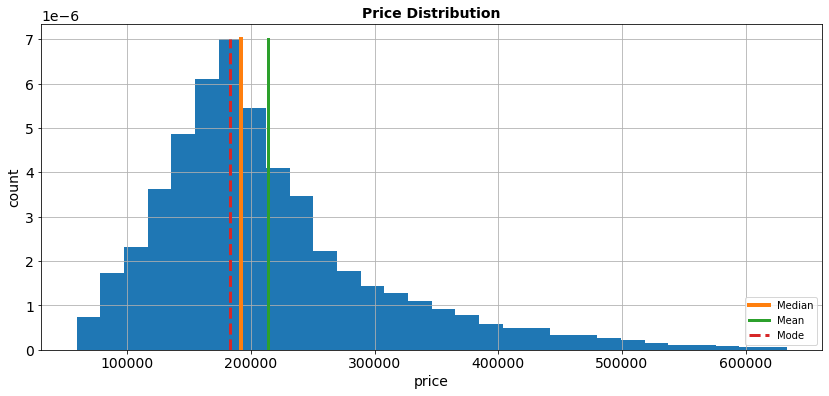

In [11]:
plt.figure(figsize = (14, 6))
train_df['Price'].hist(density=True, bins=30)
y = np.linspace(0, 0.000007, 10)
train_df_med = train_df['Price'].median()
train_df_mean = train_df['Price'].mean()
train_df_mode = train_df['Price'].mode()[0]
plt.plot([train_df_med] * 10, y, label="Median", linewidth=4)
plt.plot([train_df_mean] * 10, y, label="Mean", linewidth=3)
plt.plot([train_df_mode] * 10, y, label="Mode", linewidth=3,linestyle='dashed')
plt.ylabel('count')
plt.xlabel('price')

plt.title('Price Distribution', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10, frameon='False')
plt.show()

## Обзор переменных

In [12]:
df_num = train_df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num.describe()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.0000,10000.000000,5202.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,12.6094,0.118858,1142.904419,214138.937500
std,0.839522,21.058716,86.241219,28.560839,6.7762,0.119025,1021.519470,92872.273438
min,0.000000,1.136859,0.370619,0.000000,0.0000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,9.0000,0.017647,350.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,13.0000,0.075424,900.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,17.0000,0.195781,1548.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,117.0000,0.521867,4849.000000,633233.437500


In [13]:
train_df['Id'].value_counts()

11809    1
2906     1
5039     1
6213     1
12319    1
        ..
2351     1
13054    1
1512     1
11813    1
7202     1
Name: Id, Length: 10000, dtype: int64

In [14]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [15]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [16]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов и пропусков

In [18]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [19]:
# Работаем с  "Rooms"
rooms_med = train_df['Rooms'].median()
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_med

In [20]:
# "LifeSquare" и "KitchenSquare"
lifesq_med = train_df['LifeSquare'].median()
kitchsq_med = train_df['KitchenSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] > 400, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
train_df.loc[train_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [21]:
# Работаем с выбросами "Square"
square_med = train_df['Square'].median()
train_df.loc[train_df['Square'] < 16, 'Square'] = square_med
train_df.loc[train_df['Square'] > 400, 'Square'] = square_med

In [22]:
# Работаем с выбросами  "Floor" и "HouseFloor"
hfloor_med = train_df['HouseFloor'].median()
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

ind = train_df[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[ind, 'Floor'] = train_df.loc[ind, 'HouseFloor']

In [23]:
# Работаем с выбросами  "HouseYear"
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [24]:
# Преобразование в бинарный тип
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [25]:
# Обработка пропусков в признаке Healthcare_1
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

## Контроль пропусков

In [26]:
len(train_df) - train_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

##  Создаем и добавляем новые признаки

In [27]:
train_df['PricePerMeter'] = train_df['Price'] / train_df['Square']
train_df['PricePerMeter']
# Вычисляем "PricePerMeter" - стоимость квадратного метра общей площади


0       2651.708252
1       4462.045898
2       3600.596680
3       4160.019531
4       5351.088867
           ...     
9995    2431.568115
9996    3105.618652
9997    5597.463379
9998    5315.213379
9999    4961.141113
Name: PricePerMeter, Length: 10000, dtype: float32

In [28]:
# создаем новые признаки m2_PriceByDistrict - медианная стоимость квадратного метра в зависимости от района 
# и m2_HouseFloor - медианная стоимость квадратного метра в зависимости от этажа дома
m2_PriceByDistrict = train_df.groupby(['DistrictId'], as_index=False).agg({'PricePerMeter':'median'})\
                    .rename(columns={'PricePerMeter':'m2_PriceByDistrict'})
m2_HouseFloor = train_df.groupby(['HouseFloor'], as_index=False).agg({'PricePerMeter':'median'})\
                    .rename(columns={'PricePerMeter':'m2_HouseFloor'})

In [29]:
# Добавляем новые признаки к датасету
train_df = train_df.merge(m2_PriceByDistrict, on=['DistrictId'], how='left')
train_df = train_df.merge(m2_HouseFloor, on=['HouseFloor'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,PricePerMeter,m2_PriceByDistrict,m2_HouseFloor
0,11809,27,3.0,115.027313,32.781261,10.0,4.0,10.0,2014,0.075424,...,0,0,B,305018.875000,1,1,1,2651.708252,2759.086182,4017.350098
1,3013,22,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,0.118537,...,1,0,B,177734.546875,1,1,1,4462.045898,3553.678467,5597.402344
2,8215,1,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,0.025609,...,3,1,B,282078.718750,1,1,1,3600.596680,3251.647461,3158.411133
3,2352,1,1.0,40.409908,32.781261,6.0,10.0,22.0,1977,0.007122,...,0,1,B,168106.000000,1,1,1,4160.019531,3251.647461,4221.514160
4,13866,94,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,0.282798,...,0,6,B,343995.093750,1,1,1,5351.088867,4219.992676,4543.665039


## Отбор признаков

In [30]:

feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm2_PriceByDistrict', 'm2_HouseFloor', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [31]:
df = train_df[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m2_PriceByDistrict,m2_HouseFloor,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,3.0,115.027313,32.781261,10.0,4.0,10.0,2014,2759.086182,4017.350098,0.075424,11,0,0,0,1,1,1,305018.875000
1,1.0,39.832523,23.169222,8.0,7.0,8.0,1966,3553.678467,5597.402344,0.118537,30,1,1,0,1,1,1,177734.546875
2,3.0,78.342216,47.671970,10.0,2.0,17.0,1988,3251.647461,3158.411133,0.025609,33,0,3,1,1,1,1,282078.718750
3,1.0,40.409908,32.781261,6.0,10.0,22.0,1977,3251.647461,4221.514160,0.007122,1,0,0,1,1,1,1,168106.000000
4,2.0,64.285065,38.562515,9.0,16.0,16.0,1972,4219.992676,4543.665039,0.282798,33,2,0,6,1,1,1,343995.093750


## Масштабирование признаков

In [32]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [33]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m2_PriceByDistrict,m2_HouseFloor,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,1.368379,3.085284,-0.208050,0.762679,-0.755516,-0.459264,1.581696,-1.171220,0.364576,-0.364931,-0.780698,-0.337347,-0.883480,-0.880402,0.09897,0.16816,0.299864,305018.875000
1,-1.094506,-0.860325,-0.833112,0.154821,-0.177049,-0.769672,-1.024815,-0.374580,2.720373,-0.002690,0.303050,-0.295384,-0.213923,-0.880402,0.09897,0.16816,0.299864,177734.546875
2,1.368379,1.160350,0.760278,0.762679,-1.141160,0.627163,0.169836,-0.677390,-0.916070,-0.783473,0.474169,-0.337347,1.125190,-0.672333,0.09897,0.16816,0.299864,282078.718750
3,-1.094506,-0.830028,-0.208050,-0.453036,0.401417,1.403183,-0.427489,-0.677390,0.668976,-0.938799,-1.351093,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,168106.000000
4,0.136936,0.422745,0.167899,0.458750,1.558350,0.471959,-0.699001,0.293451,1.149291,1.377425,0.474169,-0.253421,-0.883480,0.368011,0.09897,0.16816,0.299864,343995.093750


## Визуализация

In [34]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

## Создаем обучающую и валидационную выборки

In [35]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.3, shuffle=True, random_state=21)

In [36]:
# Используем GradientBoostingRegressor
gb_model = GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=21)

R2:	0.953


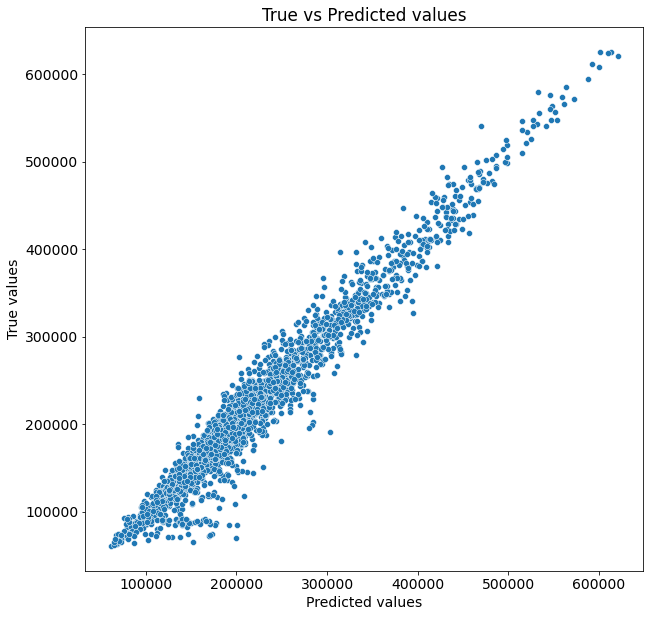

In [37]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.734


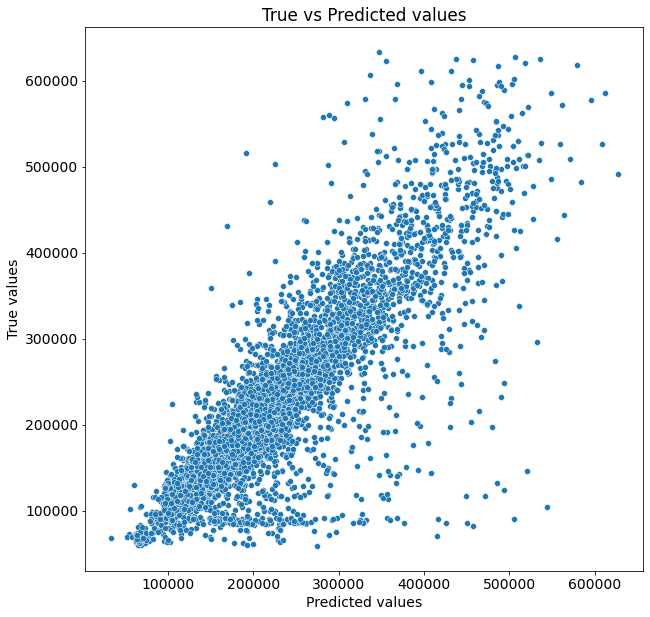

In [38]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

## Используем RandomForestRegressor

In [39]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor()

R2:	0.963


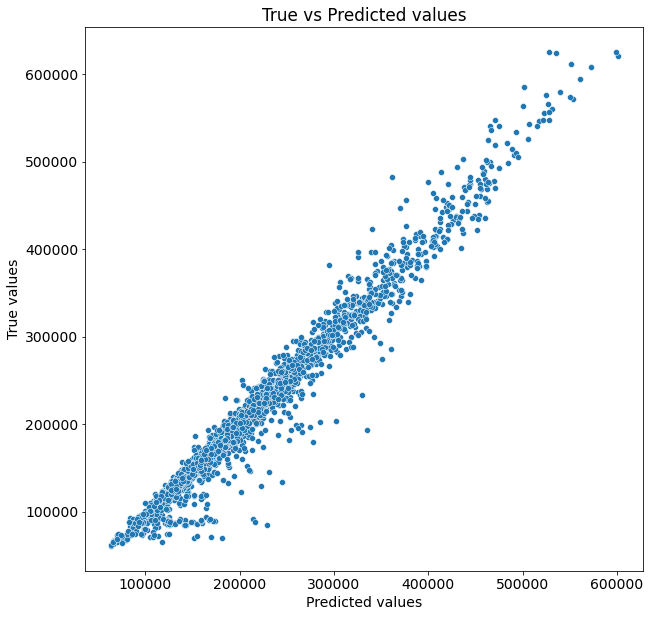

R2:	0.735


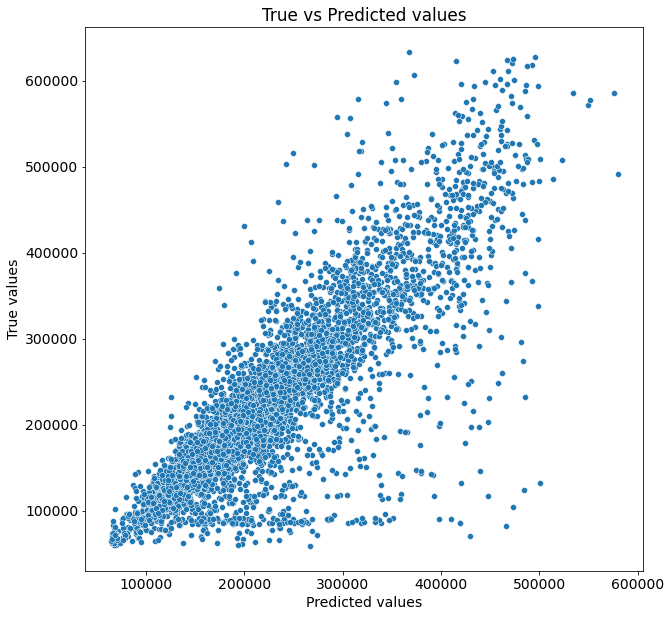

In [40]:
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_valid)
evaluate_preds(y_train, train_pred)
evaluate_preds(y_valid, test_pred)

## Проверка на валидационной выборке

R2:	0.735


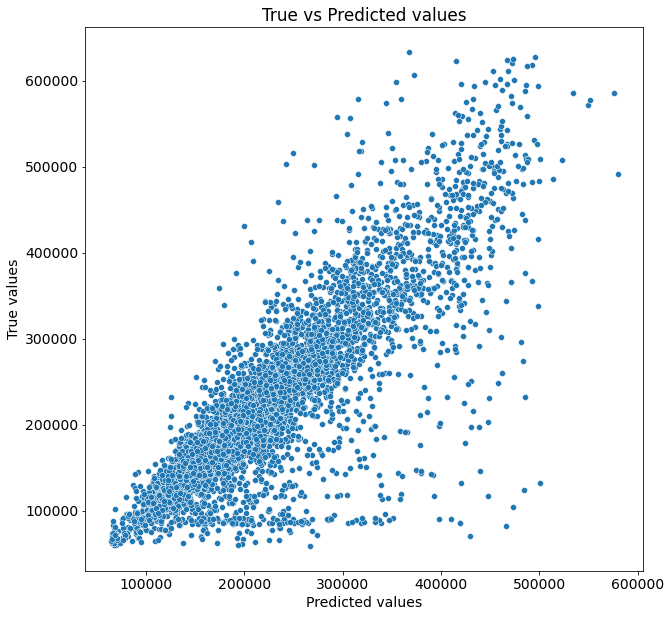

In [41]:
y_valid_preds = forest.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

## Важность признаков

In [42]:
feature_importances = pd.DataFrame(zip(X_train.columns, forest.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.419420
7,m2_PriceByDistrict,0.345032
10,Social_1,0.034345
0,Rooms,0.033481
2,LifeSquare,0.024101
6,HouseYear,0.023816
4,Floor,0.018397
3,KitchenSquare,0.017875
8,m2_HouseFloor,0.017116
5,HouseFloor,0.016117


## Обзор тестового датасета

In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

## Оптимизация и приведение типов

In [44]:
test_df = get_optimized_df(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

In [45]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


## Обзор количественных и качественных переменных

In [46]:
df_num = test_df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num.describe()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,2623.000000
mean,1.910000,56.449512,36.158756,5.976800,12.601000,0.119874,1146.657227
std,0.838586,19.092773,17.825274,9.950069,6.789165,0.120070,1044.745605
min,0.000000,1.378543,0.333490,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.906230,23.092026,1.000000,9.000000,0.019509,325.000000
50%,2.000000,52.921339,32.925087,6.000000,12.000000,0.072158,900.000000
75%,2.000000,66.285130,45.174091,9.000000,17.000000,0.195781,1548.000000
max,17.000000,223.453690,303.071106,620.000000,99.000000,0.521867,4849.000000


In [47]:
test_df.select_dtypes(include='object').columns.tolist()

['DistrictId']

In [48]:
test_df['Ecology_2'].value_counts()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [49]:
test_df['Ecology_3'].value_counts()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [50]:
test_df['Shops_2'].value_counts()

B    4588
A     412
Name: Shops_2, dtype: int64

## Работа с выбросами и пропусками

In [52]:
# Работаем с "Rooms"
test_df.loc[test_df['Rooms'].isin([0, 17]), 'Rooms'] = rooms_med

In [53]:
# "LifeSquare" и "KitchenSquare"
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
test_df.loc[test_df['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [54]:
# "Square"
test_df.loc[test_df['Square'] < 16, 'Square'] = square_med
test_df.loc[test_df['Square'] > 400, 'Square'] = square_med

In [55]:
# "Floor" и "HouseFloor"
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med
ind = test_df[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[ind, 'Floor'] = test_df.loc[ind, 'HouseFloor']

## Переводим в бинарный вид

In [56]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [57]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [58]:
len(test_df) - test_df.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

## Добавляем новые признаки к датасету

In [59]:

test_df = test_df.merge(m2_PriceByDistrict, on=['DistrictId'], how='left')
test_df = test_df.merge(m2_HouseFloor, on=['HouseFloor'], how='left')

## Обрабатываем пропуски

In [60]:
test_df.loc[test_df['m2_PriceByDistrict'].isnull(), 'm2_PriceByDistrict'] =\
                    m2_PriceByDistrict['m2_PriceByDistrict'].median()

In [61]:
test_df.loc[test_df['m2_HouseFloor'].isnull(), 'm2_HouseFloor'] =\
                    m2_HouseFloor['m2_HouseFloor'].median()

In [62]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Id                  5000 non-null   uint16  
 1   DistrictId          5000 non-null   object  
 2   Rooms               5000 non-null   float32 
 3   Square              5000 non-null   float32 
 4   LifeSquare          5000 non-null   float32 
 5   KitchenSquare       5000 non-null   float32 
 6   Floor               5000 non-null   float32 
 7   HouseFloor          5000 non-null   float32 
 8   HouseYear           5000 non-null   uint16  
 9   Ecology_1           5000 non-null   float32 
 10  Ecology_2           5000 non-null   category
 11  Ecology_3           5000 non-null   category
 12  Social_1            5000 non-null   uint8   
 13  Social_2            5000 non-null   uint16  
 14  Social_3            5000 non-null   uint8   
 15  Healthcare_1        5000 non-null   fl

In [63]:
len(test_df) - test_df.count()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Ecology_2_bin         0
Ecology_3_bin         0
Shops_2_bin           0
m2_PriceByDistrict    0
m2_HouseFloor         0
dtype: int64

## Масштабирование признаков

In [64]:
stand_features = scaler.fit_transform(test_df[feature_names])

In [65]:
test_df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

## Предсказываем цену для тестового датасета

In [66]:
X_test = test_df[feature_names]

In [80]:
y_test_preds = forest.predict(X_test)
y_test_preds

array([171068.79539062, 112793.8371875 , 142787.27710937, ...,
       150247.33953125, 186768.30804687, 294285.03289063])

In [81]:
test_df['Price'] = y_test_preds

In [82]:
test_df.to_csv(PREDICTIONS_PATHS, columns=['Id', 'Price'],index=False, encoding='utf-8')

In [83]:
pd.read_csv(PREDICTIONS_PATHS)

,Id,Price
0,4567,171068.795391
1,5925,112793.837188
2,960,142787.277109
3,3848,131524.205391
4,746,182443.011016
...,...,...
4995,10379,189360.209375
4996,16138,414589.911094
4997,3912,150247.339531
4998,5722,186768.308047
